In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
code_dir=Path.cwd()
project_dir=code_dir.parent
input_dir=project_dir/"input"
output_dir=project_dir/"output/pls/"
tmp_dir=project_dir/"tmp"

output_dir.mkdir(exist_ok=True, parents=True)

In [3]:
# Load data

y_ukb = pd.read_csv(input_dir/"y_ukb.csv", index_col=0)
y_deconfound_ukb = pd.read_csv(input_dir/"y_deconfound_ukb.csv", index_col=0)
y_ukb["cohort"] = 1
X_ukb = pd.read_csv(input_dir/"X_ukb.csv", index_col=0)


y_hchs = pd.read_csv(input_dir/"y_hchs.csv", index_col=0)
y_deconfound_hchs = pd.read_csv(input_dir/"y_deconfound_hchs.csv", index_col=0)
y_hchs["cohort"] = 0
X_hchs = pd.read_csv(input_dir/"X_hchs.csv", index_col=0)
y_hchs.columns = y_ukb.columns
y_deconfound_hchs.columns = y_deconfound_ukb.columns

In [4]:
y = pd.concat([y_ukb, y_hchs])
y_deconfound = pd.concat([y_deconfound_ukb, y_deconfound_hchs])
X = pd.concat([X_ukb, X_hchs])

In [5]:
base_variables = ["base_age","base_sex","base_isced_aggregated", "cohort"]
obesity_variables =["rf_waist_circumference", "rf_hip_circumference", "rf_waist_hip_ratio", "rf_bmi"]
bp_variables = ['rf_systolic_bp', 'rf_diastolic_bp']
lipid_variables = ['blood_hdl', "blood_ldl", "blood_cholesterol", 'blood_triglycerides']
diabetes_variables = ["blood_hba1c", "blood_glucose"]
cv_variables = obesity_variables + bp_variables + lipid_variables + diabetes_variables

variable_names = base_variables + cv_variables

# Partial least squares

In [ ]:
from confounds import Residualize
resid = Residualize()

y_base = y[base_variables]
y_risk = y[cv_variables]

resid.fit(y_risk, y_base)

y_risk_deconfound = resid.transform(y_risk, y_base)
y_deconfound = np.concatenate([y_base, y_risk_deconfound], axis=1)

In [23]:
from pyls import behavioral_pls
import warnings
import pandas as pd
warnings.simplefilter(action='ignore', category=FutureWarning)

bpls = behavioral_pls(X.values, y_deconfound, n_boot=5000, n_perm=5000)

In [ ]:
from pyls import save_results
save_results(output_dir/"pls", bpls)

In [7]:
from pyls import load_results
bpls = load_results(output_dir/"pls.hdf5")

In [26]:
variable_names_styled = ["Age", "Sex", "Education", "Cohort",
    "Waist circumference", "Hip circumference", "Waist-hip ratio", "BMI",
    "Systolic BP", "Diastolic BP",
    "HDL", "LDL", "Total cholesterol", "Triglycerides", 
    "HbA1c", "Glucose",]

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

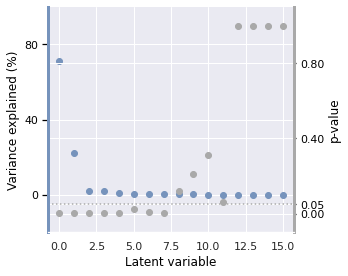

In [ ]:
latent_variables_sig = pd.DataFrame({"Explained variance (%)":bpls["varexp"] * 100,"p-value":bpls["permres"]["pvals"]})

fig = plt.figure(figsize=(5,4))

ax = fig.add_subplot(111)
ax2 = ax.twinx()

ax_color="#7693bc"
ax.plot(latent_variables_sig.index, latent_variables_sig["Explained variance (%)"], "o", color=ax_color)
ax.set_xlabel("Latent variable", size=12, color="black")
ax.set_ylabel("Variance explained (%)", size=12,color="black")
ax.tick_params(axis="y", colors="black")
ax.spines["top"].set_visible(False)
ax.set_ylim(-0.1,1)
ax.set_yticks(ax.get_yticks() * 100)
ax.locator_params(axis="y",nbins=4)

ax2_color="darkgray"
ax2.plot(latent_variables_sig.index, latent_variables_sig["p-value"], "o", color=ax2_color)
ax2.set_ylabel("p-value", color="black", size=12)
ax2.spines["right"].set_color(ax2_color)
ax2.spines["right"].set_linewidth(3)
ax2.spines["left"].set_color(ax_color)
ax2.spines["left"].set_linewidth(3)
ax2.tick_params(axis="y", colors="black", size=2)
ax2.spines["top"].set_visible(False)
ax2.set_ylim(-0.1,1.1)
ax2.set_yticks([0.  , 0.4 , 0.8 , 0.05])
ax2.locator_params(axis="y",nbins=4)

plt.axhline(y=0.05, color=ax2_color, linestyle='dotted')

plt.tight_layout()
plt.savefig(f"{output_dir}/explained_variance.png", dpi=300, bbox_inches='tight')


In [ ]:
print(latent_variables_sig["Explained variance (%)"])

0     7.119616e+01
1     2.233312e+01
2     2.123574e+00
3     1.842469e+00
4     1.032406e+00
5     5.205907e-01
6     3.777643e-01
7     2.320657e-01
8     1.754463e-01
9     1.613675e-01
10    3.027962e-03
11    2.011592e-03
12    1.884102e-30
13    1.457252e-30
14    6.097224e-31
15    2.004100e-31
Name: Explained variance (%), dtype: float64


In [12]:
latent_variables_sig.to_csv(output_dir/"latent_variable_details.csv")

In [30]:
loadings_df = pd.DataFrame({"y_loadings":bpls["bootres"]["y_loadings"][:,0],
"y_loadings_ci_lower":bpls["bootres"]["y_loadings_ci"][:,0][:,0],
"y_loadings_ci_upper":bpls["bootres"]["y_loadings_ci"][:,0][:,1]}, index=variable_names_styled)
loadings_df.to_csv(output_dir/"loadings_df_ukb.csv")

In [ ]:
loadings_df

,y_loadings,y_loadings_ci_lower,y_loadings_ci_upper
Age,8.981835e-18,-0.009236,0.009246
Sex,7.579608e-19,-0.009200,0.009096
Education,1.091463e-17,-0.008955,0.009110
Cohort,-1.591718e-18,-0.007533,0.007377
Waist circumference,-2.300677e-01,-0.238877,-0.221620
Hip circumference,-1.867756e-01,-0.195431,-0.178382
Waist-hip ratio,-1.667762e-01,-0.175862,-0.157843
BMI,-2.341093e-01,-0.242901,-0.225686
Systolic BP,-8.913975e-02,-0.098250,-0.080267
Diastolic BP,-1.158029e-01,-0.124796,-0.107148


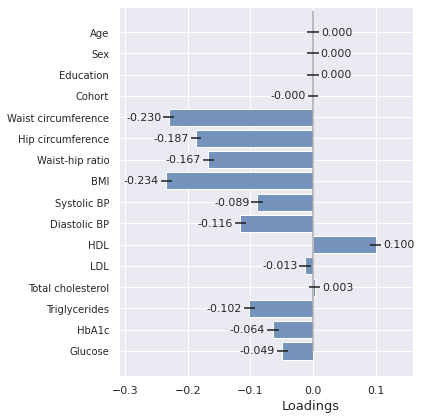

In [ ]:
import matplotlib.pyplot as plt
y_loadings = pd.DataFrame({"y_loadings":bpls["bootres"]["y_loadings"][:,0],
"y_loadings_ci_lower":bpls["bootres"]["y_loadings_ci"][:,0][:,0],
"y_loadings_ci_upper":bpls["bootres"]["y_loadings_ci"][:,0][:,1]},
index=variable_names_styled)
y_loadings["y_loadings_ci_lower_offset"] = np.abs(y_loadings["y_loadings_ci_lower"] - y_loadings["y_loadings"])
y_loadings["y_loadings_ci_upper_offset"] = np.abs(y_loadings["y_loadings_ci_upper"] - y_loadings["y_loadings"])

fig,ax = plt.subplots(1, figsize=(6,6))
ax.vlines(0,ymin=-1,ymax=15, colors='darkgray')
bars = ax.barh(y=y_loadings.index, width=y_loadings.y_loadings, color="#7693bc",
    xerr=[y_loadings.y_loadings_ci_lower_offset,y_loadings.y_loadings_ci_upper_offset])
variable_names = base_variables + cv_variables
plt.yticks(ticks=list(range(len(variable_names_styled))), labels=variable_names_styled, size=10)
plt.xlabel("Loadings",horizontalalignment="right", position=(0.75,0), size=13)
ax.invert_yaxis()
ax.bar_label(bars, fmt="%.3f", padding=2, size=11)
ax.set_xlim(-0.31, 0.16)

plt.tight_layout()
plt.savefig(output_dir/"barplot_phenotypical_loadings.png", dpi=300)

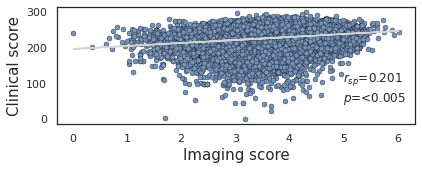

In [ ]:
import seaborn as sns
from scipy.stats import spearmanr
sns.set(rc={'figure.figsize':(6,2.5)}, style="white")
scores_correlation = pd.DataFrame({"Imaging score":bpls["x_scores"][:,0],"Clinical score":bpls["y_scores"][:,0]}, index=X.index)

scores_correlation["Imaging score"] = scores_correlation["Imaging score"] + (np.nanmin(scores_correlation["Imaging score"]) * -1)
scores_correlation["Clinical score"] = scores_correlation["Clinical score"] + (np.nanmin(scores_correlation["Clinical score"]) * -1)

ax = sns.scatterplot(x="Imaging score", y="Clinical score", data=scores_correlation, alpha=1, s=25, color="#7693bc",
    edgecolor="black", linewidth=0.3)


m, b = np.polyfit(scores_correlation["Imaging score"], scores_correlation["Clinical score"], 1)
ax.plot(scores_correlation["Imaging score"], m * scores_correlation["Imaging score"] + b, color="lightgray")

plt.tight_layout()

corr,pval = spearmanr(scores_correlation["Imaging score"], scores_correlation["Clinical score"], nan_policy="omit")
if pval < 0.005: pval = "<0.005"
plt.xlabel("Imaging score", size=15)
plt.ylabel("Clinical score", size=15)
plt.annotate(f'$r_{{sp}}$={corr:0.3} \n$p$={pval}', xy=(5,50))
plt.savefig(output_dir/"scatterplot_correlation_scores.png", dpi=300)

# Surface visualization

In [ ]:
from brainstat.datasets import fetch_mask, fetch_template_surface

# Load behavioral markers
pial_left, pial_right = fetch_template_surface("fslr32k", join=False)
pial_combined = fetch_template_surface("fslr32k", join=True)
mask = fetch_mask("fslr32k")


In [ ]:
import numpy as np
from brainspace.plotting import plot_hemispheres


def local_plot_hemispheres(values, label_text, color_range, cmap="coolwarm_r"):
    # Plot cortical surfaces with values as the data, label_text as
    # the labels, and color_range as the limits of the color bar.
    return plot_hemispheres(
        pial_left,
        pial_right,
        values,
        color_bar=True,
        color_range=color_range,
        label_text=label_text,
        cmap=cmap,
        embed_nb=True,
        size=(1400, 200),
        zoom=1.45,
        nan_color=(0.5, 0.5, 0.5, 1),
        cb__labelTextProperty={"fontSize": 12},
        interactive=False,
    )

In [ ]:
from enigmatoolbox.utils.parcellation import parcel_to_surface

bootstrap_pls_schaefer = bpls["bootres"]["x_weights_normed"][:400,0]
bootstrap_pls_fslr32k = parcel_to_surface(bootstrap_pls_schaefer, "schaefer_400_conte69")
bootstrap_pls_fslr32k_sig = bootstrap_pls_fslr32k.copy()
bootstrap_pls_fslr32k_sig[(bootstrap_pls_fslr32k_sig<1.96)& (bootstrap_pls_fslr32k_sig>-1.96)] = np.nan

In [ ]:
bootstrap_pls_schaefer_df = pd.DataFrame(bootstrap_pls_schaefer, index=X.columns[:400])
bootstrap_pls_schaefer_df.to_csv(output_dir/"pls_combined_bootstrap_schaefer_df.csv")
bootstrap_pls_schaefer_df.to_csv(input_dir/f"/cortical_maps/pls_combined_bootstrap_df.csv")

In [ ]:
color_range_max = np.nanmean(bootstrap_pls_fslr32k_sig.squeeze().astype(float)) + np.nanstd(bootstrap_pls_fslr32k_sig.squeeze().astype(float)) * 0.5
img = local_plot_hemispheres(bootstrap_pls_fslr32k_sig.squeeze().astype(float), ["Bootstrap ratio"],(-color_range_max, color_range_max), cmap="RdYlBu")
open(output_dir/f"bootstrap_ratio.png", "wb").write(img.data)

224376

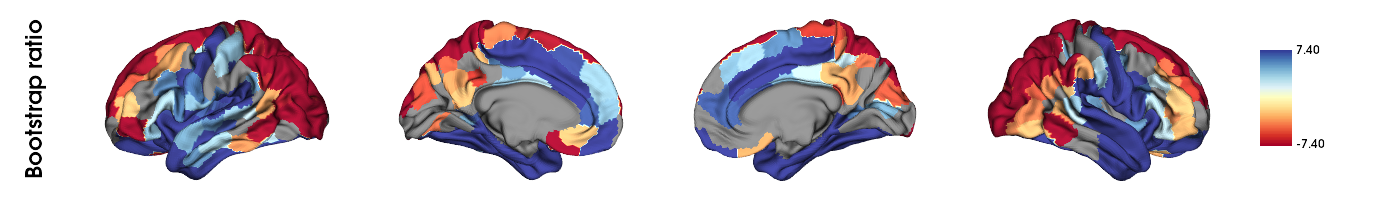

In [ ]:
img

In [ ]:
bootstrap_pls_tian = bpls["bootres"]["x_weights_normed"][400:,0]
bootstrap_pls_tian_sig = bootstrap_pls_tian.copy()
bootstrap_pls_tian_sig[(bootstrap_pls_tian_sig<1.96)& (bootstrap_pls_tian_sig>-1.96)] = 0
bootstrap_pls_tian_dict = pd.DataFrame(bootstrap_pls_tian_sig, index = X.columns[-14:]).to_dict()[0]


import numpy as np

from enigmatoolbox.datasets import load_sc, load_fc

from nilearn import plotting

# Load cortico-cortical functional connectivity data

_, _, _, sctx_labels, = load_fc()

mapping_subcortical = {
 'Laccumb':'NAc-lh', 
 'Lamyg':'AMY-lh',
 'Lcaud':'CAU-lh',
 'Lhippo':'HIP-lh',
 'Lpal':'GP-lh',
 'Lput':'PUT-lh',
 'Lthal':'THA-lh',
 'Raccumb':'NAc-rh',
 'Ramyg':'AMY-rh',
 'Rcaud':'CAU-rh',
 'Rhippo':'HIP-rh',
 'Rpal':'GP-rh',
 'Rput':'PUT-rh',
 'Rthal':'THA-rh'}

from enigmatoolbox.plotting import plot_subcortical

# Project the results on the surface brain

# for k,v in bootstrap_pls_tian_dict.items():

values = []
for label in sctx_labels:
    label_mapped = mapping_subcortical[label]
    if label_mapped: values = np.append(values, bootstrap_pls_tian_dict[label_mapped])
    else: values = np.append(values, 0)

    values = np.nan_to_num(values, copy=True, nan=0)
    values = np.array(values)

plot = plot_subcortical(array_name=values, size=(800, 200),

                cmap='RdYlBu', color_bar=True, color_range=(-color_range_max, color_range_max),
                
                embed_nb=True, interactive=False, ventricles = False, transparent_bg=False,
                
                screenshot=True, filename=f"{output_dir}/bootstrap_ratio_tian.png", scale=4)

# Schaefer 100

In [40]:
X_schaefer100_ukb = pd.read_csv(input_dir/"X_ukb_schaefer100.csv", index_col=0)
X_schaefer100_hchs = pd.read_csv(input_dir/"X_hchs_schaefer100.csv", index_col=0)

In [41]:
X_schaefer100 = pd.concat([X_schaefer100_ukb, X_schaefer100_hchs], axis=0)

In [74]:
from pyls import behavioral_pls
import warnings
import pandas as pd
warnings.simplefilter(action='ignore', category=FutureWarning)

bpls2 = behavioral_pls(X_schaefer100, y_deconfound, n_boot=5000, n_perm=5000)

In [75]:
from enigmatoolbox.utils.parcellation import parcel_to_surface

bootstrap_pls_schaefer = bpls2["bootres"]["x_weights_normed"][:,0]
bootstrap_pls_fslr32k = parcel_to_surface(bootstrap_pls_schaefer100, "schaefer_100_conte69")
bootstrap_pls_fslr32k_sig = bootstrap_pls_fslr32k.copy()
bootstrap_pls_fslr32k_sig[(bootstrap_pls_fslr32k_sig<1.96)& (bootstrap_pls_fslr32k_sig>-1.96)] = np.nan

In [88]:
bootstrap_pls_schaefer_df = pd.DataFrame(bootstrap_pls_schaefer, index=X_schaefer100.columns)
bootstrap_pls_schaefer_df.to_csv(output_dir/"pls_ukb_bootstrap_schaefer100_df.csv", index=False, header=None)

In [77]:
color_range_max = np.nanmean(bootstrap_pls_fslr32k_sig.squeeze().astype(float)) + np.nanstd(bootstrap_pls_fslr32k_sig.squeeze().astype(float)) * 0.5
img = local_plot_hemispheres(bootstrap_pls_fslr32k_sig.squeeze().astype(float), ["Bootstrap ratio"],(-color_range_max, color_range_max), cmap="RdYlBu")
open(output_dir/f"bootstrap_ratio100.png", "wb").write(img.data)

227786

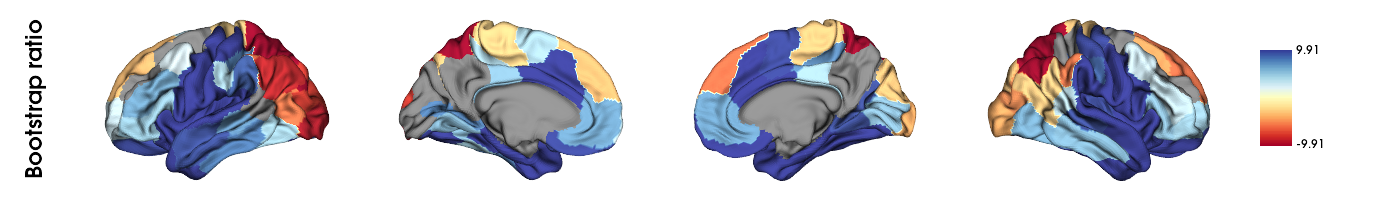

In [ ]:
img

# Correlation matrix

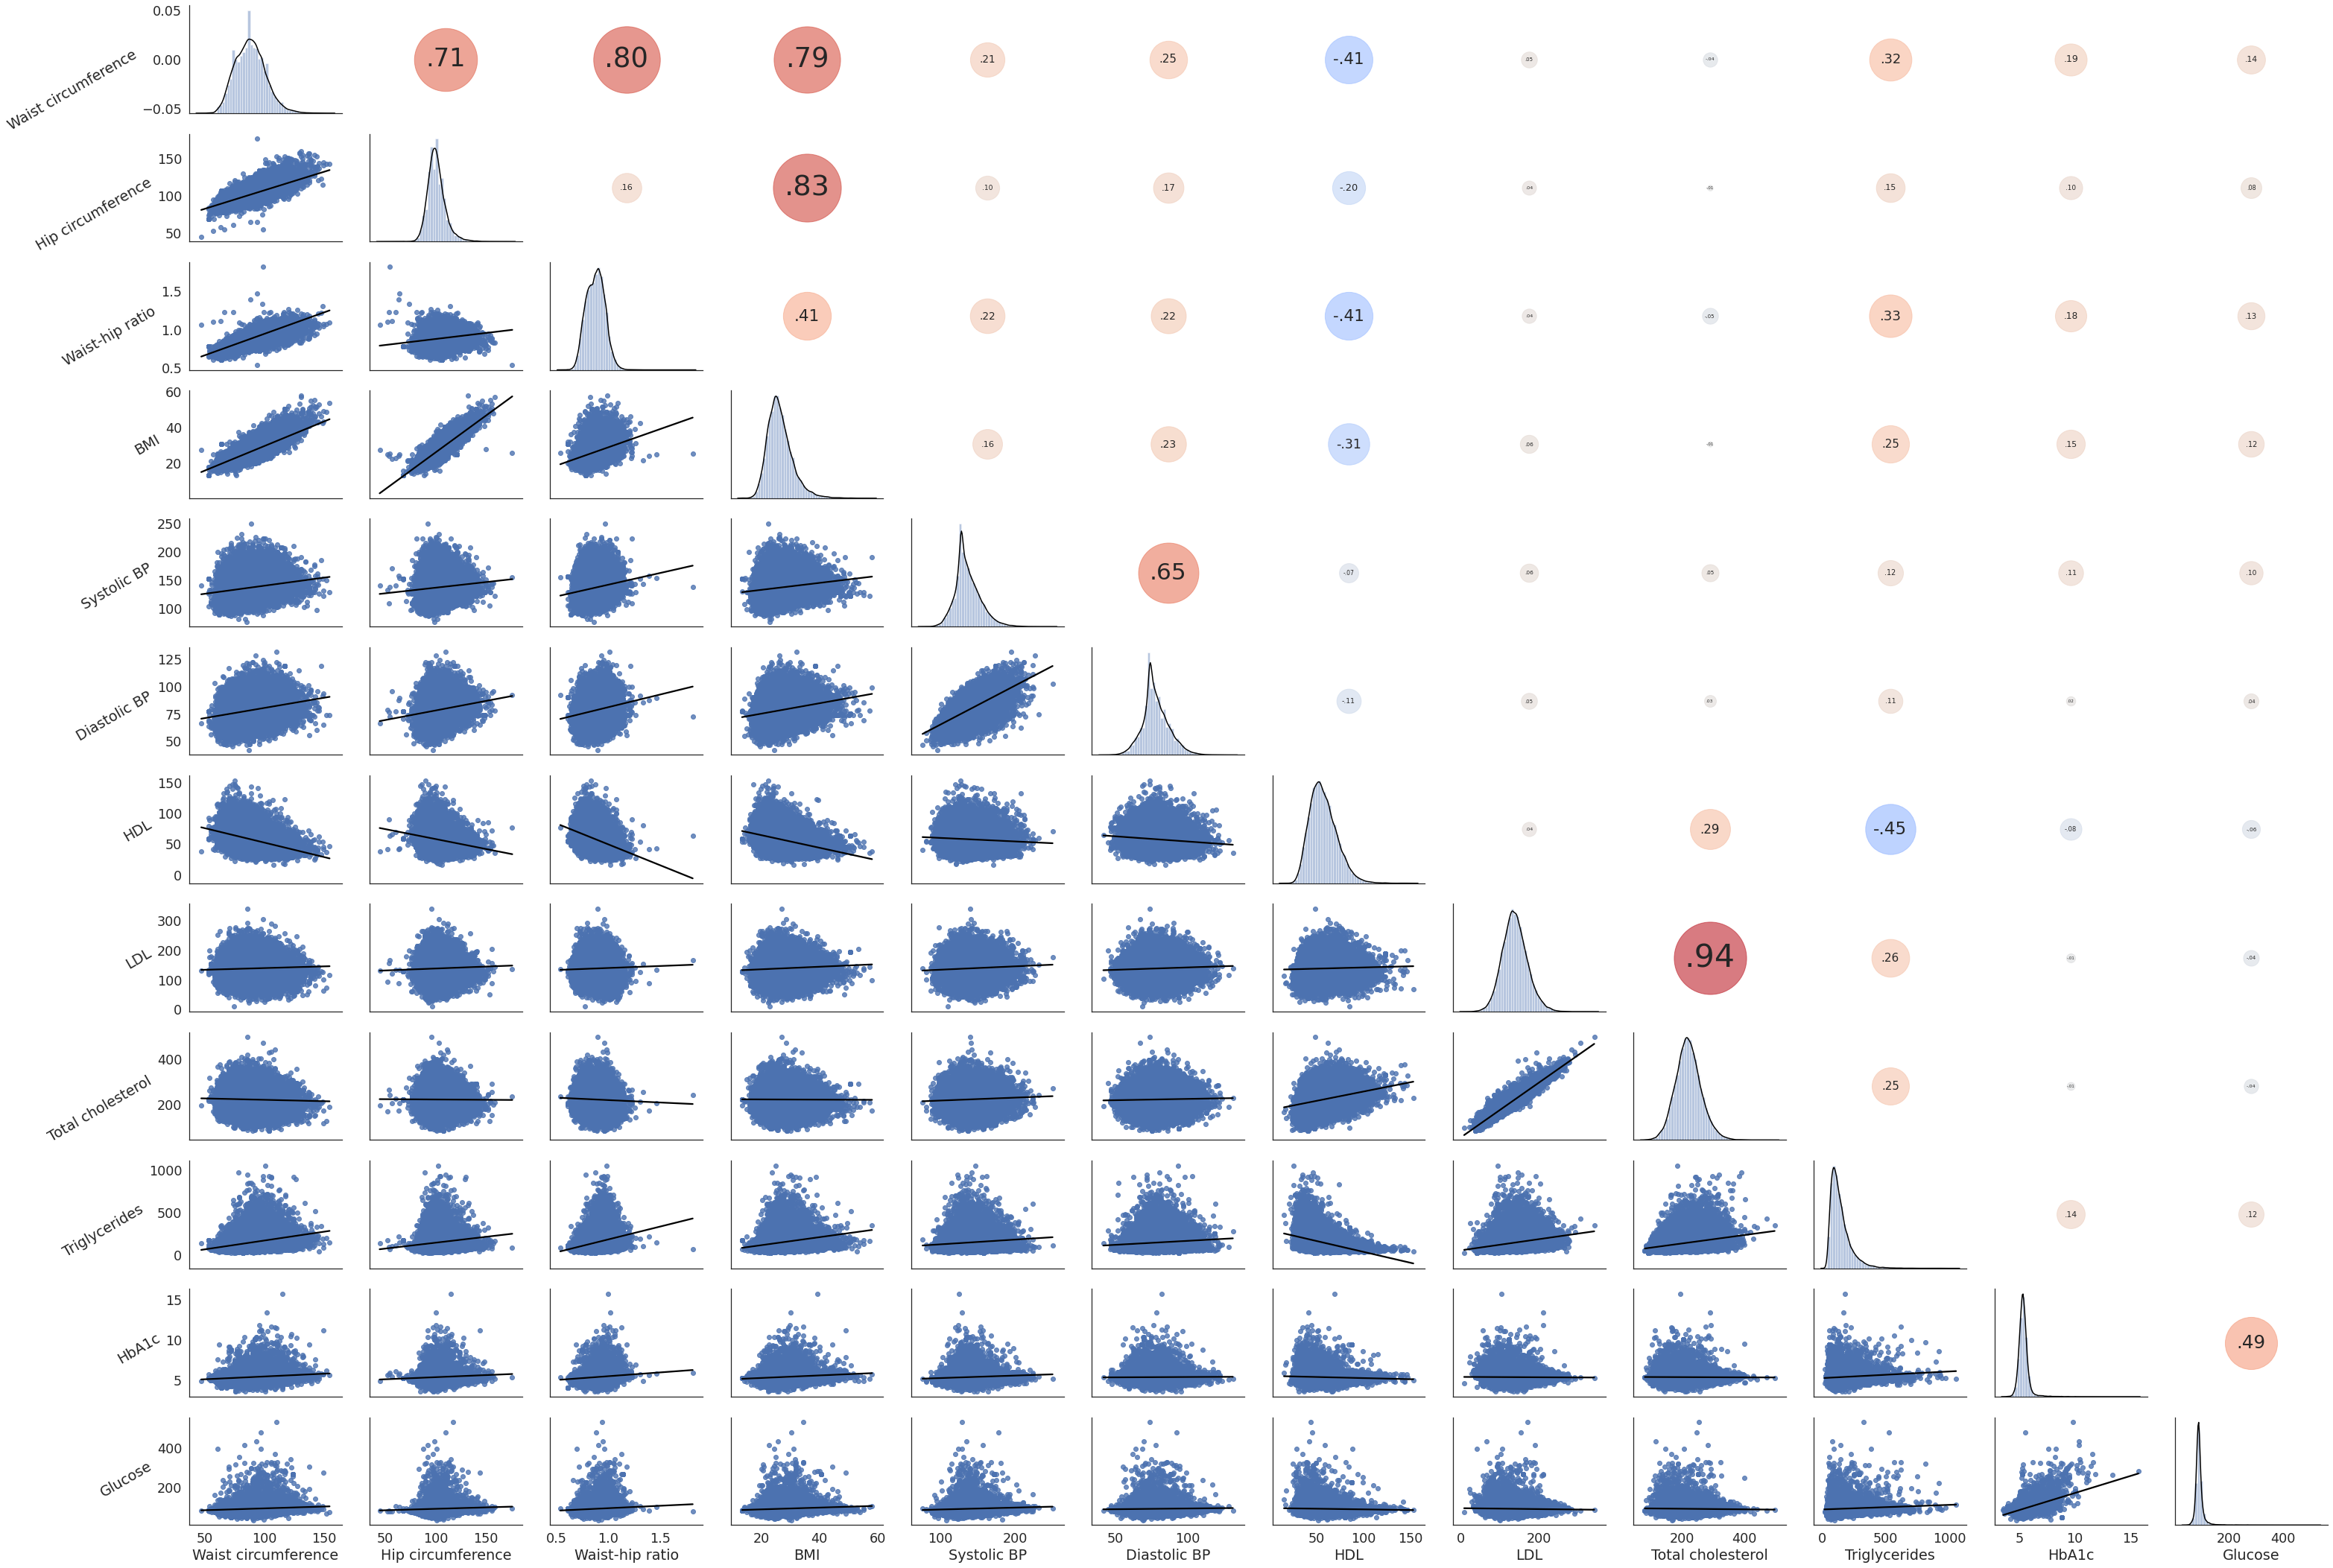

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

sns.set(style='white', font_scale=1.6)
df = y[cv_variables]
df.columns = variable_names_styled[4:]

g = sns.PairGrid(df, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=False, ci=False, line_kws={'color': 'black'}) # lowess=True,
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)

for ax in g.axes.flatten():
    ax.set_ylabel(ax.get_ylabel(), rotation = 30)
    ax.yaxis.get_label().set_horizontalalignment('right')

plt.savefig(output_dir/"cv_variables_correlations.png", dpi=300, bbox_inches='tight')



# Cross validation

In [159]:
X_pls = X.reset_index(drop=True)
Y_pls = y.reset_index(drop=True)

In [170]:
cross_validation_df = X.join(y)
cross_validation_df = cross_validation_df.reset_index(drop=True)

In [171]:
X_pls = cross_validation_df[X.columns]
Y_pls = cross_validation_df[y.columns]

In [172]:
from sklearn.cross_decomposition import PLSCanonical
plsca = PLSCanonical(n_components=1)
plsca.fit(X_pls, Y_pls)
X_c, Y_c = plsca.transform(X_pls, Y_pls)

In [ ]:
from pingouin import corr
corr(X_c.flatten(), Y_c.flatten(), method='spearman')

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=False)

cv_dict = dict()

idx=1
for train_index, test_index in kf.split(X_pls):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_pls.loc[train_index], X_pls.loc[test_index]
    y_train, y_test = Y_pls.loc[train_index], Y_pls.loc[test_index]
    plsca = PLSCanonical(n_components=1)
    plsca.fit(X_train, y_train)
    X_c, Y_c = plsca.transform(X_test, y_test)
    cv_dict[idx] = dict(X_c=X_c.flatten(), Y_c=Y_c.flatten())
    idx+=1

In [175]:
from pingouin import corr

r_dict = dict()
p_dict = dict()

for k,v in cv_dict.items():
    spearman = corr(v['X_c'], v['Y_c'], method='spearman')
    r_dict[k] = float(spearman['r'].values)
    p_dict[k] = float(spearman['p-val'].values)

In [176]:
from pingouin import multicomp
pval_fdr = multicomp(list(p_dict.values()), method='fdr_bh')[1]

In [177]:
pd.DataFrame([r_dict.values(),  p_dict.values(), pval_fdr,], index=["r","p","p_fdr"]).T.to_csv(output_dir/"cv_results.csv")

In [ ]:
pd.DataFrame([r_dict.values(),  p_dict.values(), pval_fdr,], index=["r","p","p_fdr"]).mean(axis=1)

# LV 2

In [47]:
loadings_df = pd.DataFrame({"y_loadings":bpls["bootres"]["y_loadings"][:,1],
"y_loadings_ci_lower":bpls["bootres"]["y_loadings_ci"][:,1][:,0],
"y_loadings_ci_upper":bpls["bootres"]["y_loadings_ci"][:,1][:,1]}, index=variable_names_styled)
loadings_df.to_csv(output_dir/"lv2_loadings_df_ukb.csv")

In [48]:
loadings_df

,y_loadings,y_loadings_ci_lower,y_loadings_ci_upper
Age,0.004211,-0.005167,0.013418
Sex,0.002955,-0.006714,0.012368
Education,-0.003016,-0.012624,0.006603
Cohort,-0.000019,-0.008714,0.008817
Waist circumference,-0.014715,-0.024274,-0.005303
Hip circumference,0.005910,-0.003264,0.015350
Waist-hip ratio,-0.025599,-0.034930,-0.015985
BMI,0.003949,-0.005455,0.013575
Systolic BP,-0.006041,-0.015965,0.003635
Diastolic BP,0.010002,0.000480,0.019854


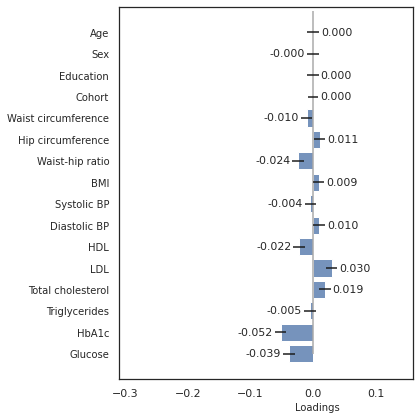

In [ ]:
import matplotlib.pyplot as plt
y_loadings = pd.DataFrame({"y_loadings":bpls["bootres"]["y_loadings"][:,1],
"y_loadings_ci_lower":bpls["bootres"]["y_loadings_ci"][:,1][:,0],
"y_loadings_ci_upper":bpls["bootres"]["y_loadings_ci"][:,1][:,1]},
index=variable_names_styled)
y_loadings["y_loadings_ci_lower_offset"] = np.abs(y_loadings["y_loadings_ci_lower"] - y_loadings["y_loadings"])
y_loadings["y_loadings_ci_upper_offset"] = np.abs(y_loadings["y_loadings_ci_upper"] - y_loadings["y_loadings"])

fig,ax = plt.subplots(1, figsize=(6,6))
ax.vlines(0,ymin=-1,ymax=15, colors='darkgray')
bars = ax.barh(y=y_loadings.index, width=y_loadings.y_loadings, color="#7693bc",
    xerr=[y_loadings.y_loadings_ci_lower_offset,y_loadings.y_loadings_ci_upper_offset])
variable_names = base_variables + cv_variables
plt.yticks(ticks=list(range(len(variable_names_styled))), labels=variable_names_styled, size=10)
plt.xlabel("Loadings",horizontalalignment="right", position=(0.75,0), size=10)
ax.invert_yaxis()
ax.bar_label(bars, fmt="%.3f", padding=2, size=11)
ax.set_xlim(-0.31, 0.16)

plt.tight_layout()
plt.savefig(output_dir/"lv2_barplot_phenotypical_loadings.png", dpi=300)

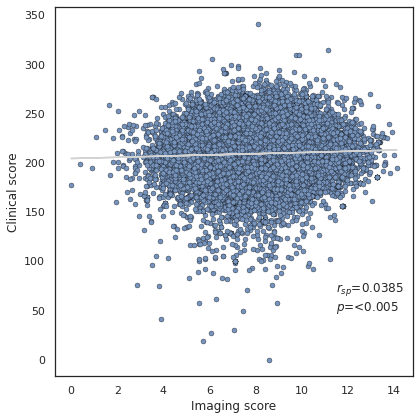

In [ ]:
import seaborn as sns
from scipy.stats import spearmanr
sns.set(rc={'figure.figsize':(6,6)}, style="white")
scores_correlation = pd.DataFrame({"Imaging score":bpls["x_scores"][:,1],"Clinical score":bpls["y_scores"][:,1]}, index=X.index)

scores_correlation["Imaging score"] = scores_correlation["Imaging score"] + (np.nanmin(scores_correlation["Imaging score"]) * -1)
scores_correlation["Clinical score"] = scores_correlation["Clinical score"] + (np.nanmin(scores_correlation["Clinical score"]) * -1)

ax = sns.scatterplot(x="Imaging score", y="Clinical score", data=scores_correlation, alpha=1, s=25, color="#7693bc",
    edgecolor="black", linewidth=0.3)


m, b = np.polyfit(scores_correlation["Imaging score"], scores_correlation["Clinical score"], 1)
ax.plot(scores_correlation["Imaging score"], m * scores_correlation["Imaging score"] + b, color="lightgray")

plt.tight_layout()

corr,pval = spearmanr(scores_correlation["Imaging score"], scores_correlation["Clinical score"], nan_policy="omit")
if pval < 0.005: pval = "<0.005"
plt.annotate(f'$r_{{sp}}$={corr:0.3} \n$p$={pval}', xy=(11.5,50))
plt.savefig(output_dir/"lv2_scatterplot_correlation_scores.png", dpi=300)

# Surface visualization

In [55]:
from brainstat.datasets import fetch_mask, fetch_template_surface

# Load behavioral markers
pial_left, pial_right = fetch_template_surface("fslr32k", join=False)
pial_combined = fetch_template_surface("fslr32k", join=True)
mask = fetch_mask("fslr32k")


In [56]:
import numpy as np
from brainspace.plotting import plot_hemispheres


def local_plot_hemispheres(values, label_text, color_range, cmap="coolwarm_r"):
    # Plot cortical surfaces with values as the data, label_text as
    # the labels, and color_range as the limits of the color bar.
    return plot_hemispheres(
        pial_left,
        pial_right,
        values,
        color_bar=True,
        color_range=color_range,
        label_text=label_text,
        cmap=cmap,
        embed_nb=True,
        size=(1400, 200),
        zoom=1.45,
        nan_color=(0.5, 0.5, 0.5, 1),
        cb__labelTextProperty={"fontSize": 12},
        interactive=False,
    )

In [57]:
from enigmatoolbox.utils.parcellation import parcel_to_surface

bootstrap_pls_schaefer = bpls["bootres"]["x_weights_normed"][:,1]
bootstrap_pls_fslr32k = parcel_to_surface(bootstrap_pls_schaefer, "schaefer_400_conte69")
bootstrap_pls_fslr32k_sig = bootstrap_pls_fslr32k.copy()
bootstrap_pls_fslr32k_sig[(bootstrap_pls_fslr32k_sig<1.96)& (bootstrap_pls_fslr32k_sig>-1.96)] = np.nan

In [58]:
bootstrap_pls_schaefer_df = pd.DataFrame(bootstrap_pls_schaefer, index=X.columns)
bootstrap_pls_schaefer_df.to_csv(output_dir/"lv2_pls_combined_bootstrap_schaefer_df.csv")


In [59]:
color_range_max = np.nanmean(bootstrap_pls_fslr32k_sig.squeeze().astype(float)) + np.nanstd(bootstrap_pls_fslr32k_sig.squeeze().astype(float)) * 0.5
img = local_plot_hemispheres(bootstrap_pls_fslr32k_sig.squeeze().astype(float), ["Bootstrap ratio"],(-color_range_max, color_range_max), cmap="RdYlBu")
open(output_dir/f"lv2_bootstrap_ratio.png", "wb").write(img.data)

224512

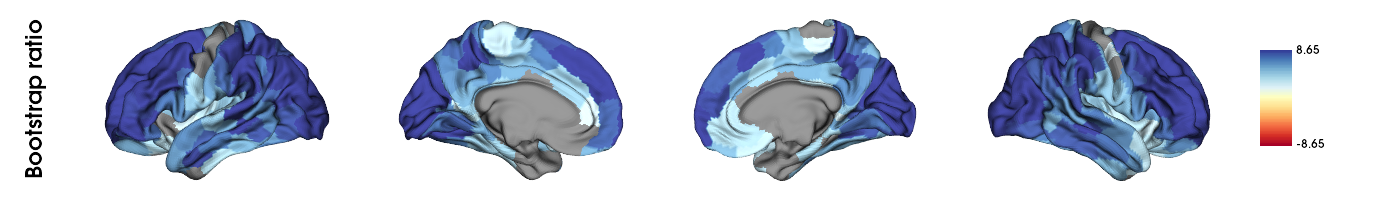

In [ ]:
img